In [1]:
from matplotlib import colormaps
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple, Dict
import pandas as pd
import os
import re
import json
import subprocess
import numpy as np
from scipy import stats
from collections import defaultdict, namedtuple
from sklearn.cluster import DBSCAN
import math as ma

#### Global variables

In [2]:
TRACE_CMD_CACHE_FILENAME = "trace_cmd_runtimes"
RESULTS_DIR_PATH = "../results"
ABSOLUTE_RESULTS_DIR_PATH = "/home/cgachod/analysis/results"

WORKING_DIR = "/root/tests"
PERF_SCRIPT_RESULTS_FILEPATH = f"{WORKING_DIR}/.perf_mem_results.log"

NODE_1_PHYS_ADDR_START = 0x1840000000

DAHU_NODE_0_CPUID = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62]
DAHU_NODE_1_CPUID = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63]
dahu_cpu_nodes = [1 if cpuid in DAHU_NODE_1_CPUID else 0 for cpuid in range(64)]

def in_working_dir(path: str) :
    return os.path.join(WORKING_DIR, path)

In [23]:
def parse_per_cpu_perf_file(file_path) -> Tuple[pd.DataFrame, Dict]:
    with open(file_path, 'r') as file:
        text = file.read()
    nas_time_match = re.search(r'Time in seconds\s+=\s+(\d*.\d*)', text)
    if nas_time_match :
        nas_time = float(nas_time_match.group(1))
        
        
    json_begin_pos = text.find('{')
    json_end_pos = text.rfind('}')
    json_text = text[json_begin_pos:json_end_pos + 1]
    json_lines = json_text.split('\n')
    
    events_df = pd.DataFrame()
    
    meta_values = {"nas_runtime": nas_time}
    
    event_counters: Dict[str, list] = defaultdict(list)
    for line in json_lines :
        json_object = json.loads(line)
        event_str = json_object["event"].strip()
        if event_str in ["duration_time", "user_time", "system_time"] :
            meta_values[event_str] = float(json_object["counter-value"])
        else :
            event_counters[event_str].append((int(json_object["cpu"]), float(json_object["counter-value"])))
        
    # Sorting by value means sorting by CPU since first object of value tuple is CPU id
    events_df = pd.DataFrame({event: [e[1] for e in sorted(values)] for event, values in event_counters.items()})
    # events_df["LLC-all-misses"] = events_df["LLC-load-misses"] + events_df["LLC-store-misses"]
    # events_df["LLC-load-misses-ratio"] = events_df["LLC-load-misses"] / events_df["LLC-loads"]
    # events_df["LLC-store-misses-ratio"] = events_df["LLC-store-misses"] / events_df["LLC-stores"]
    
    # events_df["mem_load_l3_miss_retired.all"] = events_df["mem_load_l3_miss_retired.remote_dram"] + events_df["mem_load_l3_miss_retired.local_dram"]
    # events_df["mem_load_l3_miss_retired-over-LLC-all"] = events_df["mem_load_l3_miss_retired.all"] / events_df["LLC-all-misses"]
    # events_df["mem_load_l3_miss_retired.remote_over_local_dram"] = events_df["mem_load_l3_miss_retired.remote_dram"] / events_df["mem_load_l3_miss_retired.local_dram"]
    # events_df["mem_load_l3_miss_retired.remote_over_total"] = events_df["mem_load_l3_miss_retired.remote_dram"] / events_df["mem_load_l3_miss_retired.all"]
    # events_df["mem_load_l3_miss_retired.local_over_total"] = events_df["mem_load_l3_miss_retired.local_dram"] / events_df["mem_load_l3_miss_retired.all"]
    
    return events_df, meta_values

def plot_perf_stat_per_cpu(df: pd.DataFrame, event: str, sort = False) :
    event_series = df[event]
    if sort:
        event_series = event_series.sort_values()

    bars = plt.bar(range(len(event_series)), event_series, width=0.8)
    for item in bars[::2]:
        item.set_color('tab:orange')
    plt.ylim(0, max(event_series) * 1.1)
    plt.xticks([i for i in range(65) if i % 2 == 0])
    plt.minorticks_on()
    plt.gcf().set_size_inches(15, 8)
    plt.tick_params(axis='x', which='minor', bottom=False)
    plt.title(f"Number {event} events per core\nTotal " + '{:.4e}'.format(sum(event_series)) + "")
    plt.show()

In [29]:
# stat_df = parse_per_cpu_perf_file(in_working_dir("perf-stat-l3-miss-sockorder.txt"))[0]
stat_df = parse_per_cpu_perf_file(in_working_dir("perf-stat-l3-miss-sequential.txt"))[0]

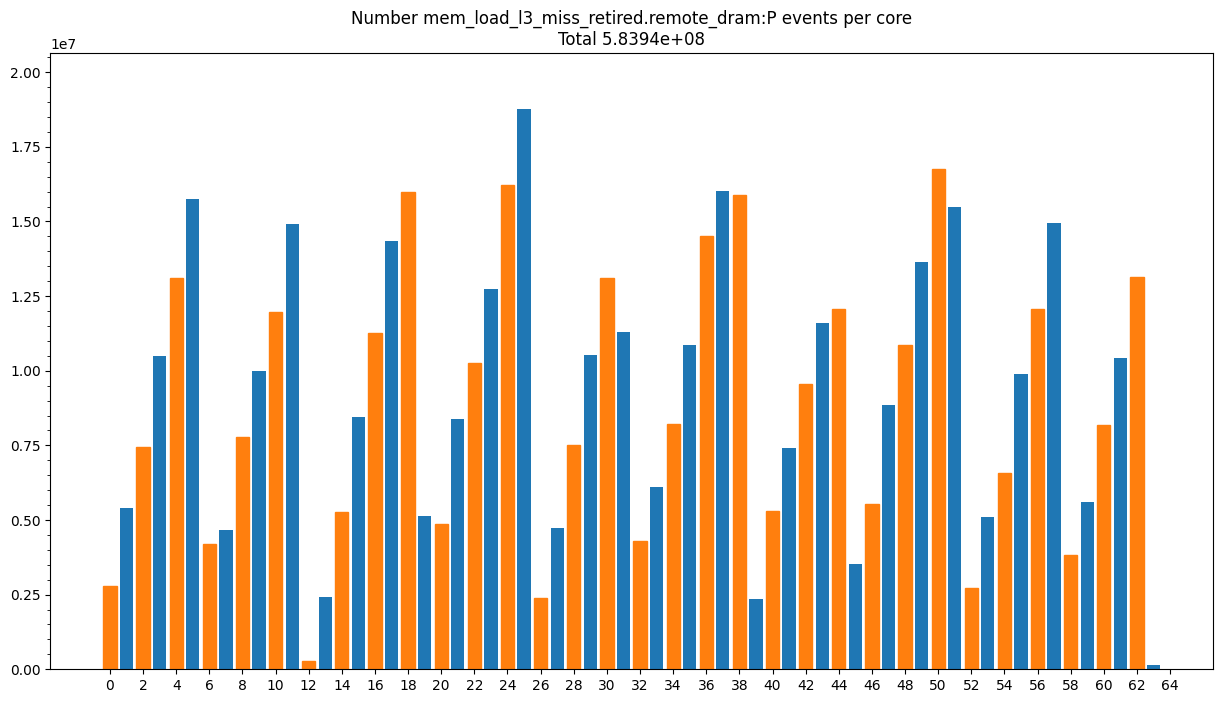

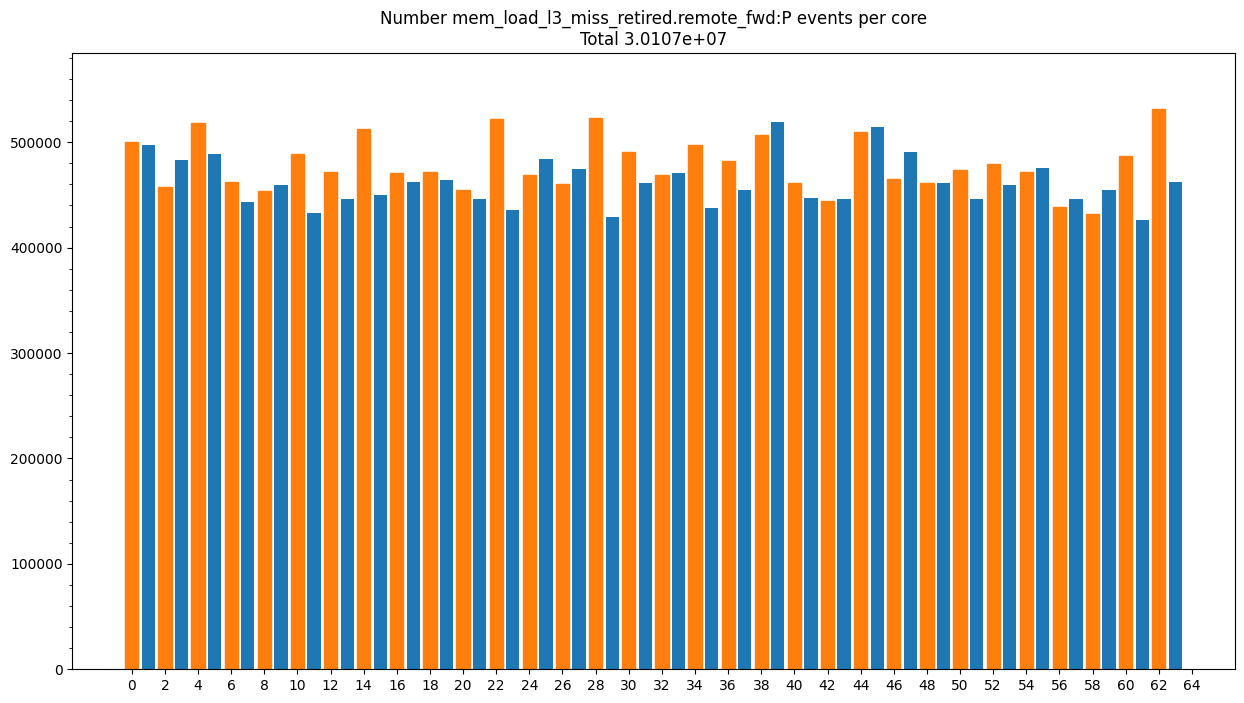

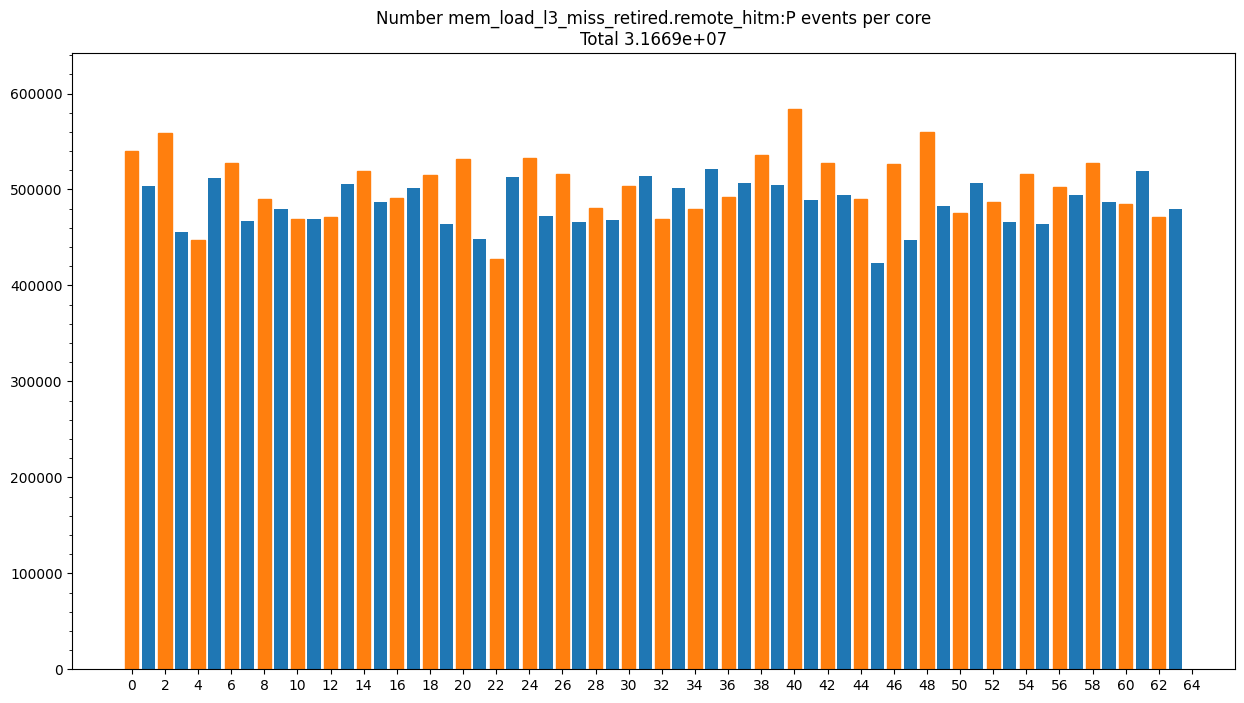

In [30]:
for event in stat_df:
    plot_perf_stat_per_cpu(stat_df, event, sort = False)

In [3]:
class PerfResultsReader:
    def __init__(self, log_file_path = in_working_dir(".perf.log")) -> None:
        self.log_file_path = log_file_path
        
    def __get_initial_timestamp(self, data_file_path: str) :
        res = subprocess.run(
            f"perf script -i {data_file_path} -F time | head -1",
            shell=True,
            stdout = subprocess.PIPE,
            universal_newlines = True
        )
        return float(res.stdout.strip(':\n '))
        
    # For example time_option="10%-20%"
    def __extract_perf_data_file_with_latency(self, data_file_path: str, executable: Optional[str], time_option: Optional[str]) -> float:
        initial_timestamp = self.__get_initial_timestamp(data_file_path)
        print(f"Retrieved initial timestamp : {initial_timestamp}")
        
        executable_filter = f"-c {executable}" if executable is not None else ""
        time_filter = f"--time {time_option}" if time_option is not None else ""
        command_str = f"perf script -i {data_file_path} -L {executable_filter} {time_filter} > {self.log_file_path}"
        print(f"Executing {command_str}")
        result = subprocess.run(
            command_str,
            shell=True,
            stdout = subprocess.PIPE,
            universal_newlines = True
        )
        return initial_timestamp
    
    def __parse_events_with_latency(self, filepath: str, initial_timestamp: float = 0.0) -> pd.DataFrame :
        # 1: pid, 2: cpuid, 3: timestamp, 4: period, 5: event, 6: virt_addr 
        basic_info_regex_lat_str = r"^ *\S+ +(\d+) +(\d+) +(\d+\.\d+): +(\d+) +(\S+): +([0-9a-f]+)"
        
        # 1: cache_result, 2: tlb_result, 3: latency, 4: phys_adress
        data_src_regex_lat_str = r"[0-9a-f]+ \|OP (?:LOAD|STORE)\|([^\|]+)\|[^\|]+\|(TLB [^\|]+)\|[^\|]+\|[a-zA-Z\/\- ]+(\d+) +\d+ +[0-9a-f]+.+ ([0-9a-f]+)"
        line_lat_regex = re.compile(basic_info_regex_lat_str + r" +" + data_src_regex_lat_str)
        
        # pid = []
        cpuid = []
        timestamp = []
        period = []
        event = []
        virtual_addr = []
        cache_result = []
        latency = []
        physical_addr = []

        with open(filepath) as f :
            for line in f :
                matched = line_lat_regex.match(line)
                if matched :
                    # pid.append(int(matched[1]))
                    cpuid.append(int(matched[2]))
                    timestamp.append(float(matched[3]))
                    period.append(int(matched[4]))
                    event.append(matched[5])
                    virtual_addr.append(int(matched[6], base=16))
                    cache_result.append(matched[7])
                    latency.append(int(matched[9]))
                    physical_addr.append(int(matched[10], base=16))
                    pass
                else :
                    print("Not matched line : ", line)
                    
        dahu_cpu_nodes_map = {cpuid: 1 if cpuid in DAHU_NODE_1_CPUID else 0 for cpuid in range(64)}
        
        events_df = pd.DataFrame({
            "cpuid": cpuid,  
            "time": timestamp, 
            "period": period,
            "event": event,
            "virt": virtual_addr,
            "phys": physical_addr, 
            "latency": latency,
            "cache_result": cache_result,
        })
        events_df['time'] = events_df['time'] - initial_timestamp
        # accesses_df['time_offset'] = accesses_df['time'].diff()
        events_df['cpu_node'] = events_df['cpuid'].map(dahu_cpu_nodes_map)
        events_df['memory_node'] = (events_df['phys'] >= NODE_1_PHYS_ADDR_START).astype(int)
        return events_df
    
    def read_perf_data_with_latency(self, data_file_path: str, executable: Optional[str] = None, time_option: Optional[str] = None) -> pd.DataFrame:
        initial_timestamp = self.__extract_perf_data_file_with_latency(data_file_path, executable, time_option)
        df = self.__parse_events_with_latency(self.log_file_path, initial_timestamp)
        os.remove(self.log_file_path)
        return df
    
    

In [4]:
prr = PerfResultsReader()
# prr.extract_perf_data_file_with_latency(data_file_path=in_working_dir("perf.data"), executable="cg.C.x")
# prr._PerfResultsReader__parse_events_with_latency(in_working_dir(".perf.sample.log"))
events_df = prr.read_perf_data_with_latency(in_working_dir("perf-mem-sequential.data"), "cg.C.x", time_option="10%-20%")

Retrieved initial timestamp : 2117.20729
Executing perf script -i /root/tests/perf-mem-sequential.data -L -c cg.C.x --time 10%-20% > /root/tests/.perf.log


Processed 38684518 events and lost 511 chunks!

Check IO/CPU overload!

Processed 43845332 samples and lost 11.83%!

1737089 out of order events recorded.


In [5]:
events_df

,cpuid,time,period,event,virt,phys,latency,cache_result,cpu_node,memory_node
0,56,1.429202,100,cpu/mem-loads/P,140403836413456,104887707152,12,LVL L1 or L1 hit,0,1
1,17,1.429202,100,mem_load_l3_miss_retired.remote_dram:P,140402985664648,7920287880,0,LVL N/A or N/A,1,0
2,10,1.429203,100,mem_load_l3_miss_retired.remote_dram:P,140402954105536,106995937984,0,LVL N/A or N/A,0,1
3,5,1.429203,100,mem_load_l3_miss_retired.remote_dram:P,140402931465408,11655642304,0,LVL N/A or N/A,1,0
4,37,1.429203,100,mem_load_l3_miss_retired.remote_dram:P,140403075743232,7890828800,0,LVL N/A or N/A,1,0
...,...,...,...,...,...,...,...,...,...,...
3483034,50,2.858402,100,mem_load_l3_miss_retired.remote_dram:P,140403134153088,106609754496,0,LVL N/A or N/A,0,1
3483035,3,2.858402,100,cpu/mem-loads/P,140403716550376,12159708904,7,LVL L1 or L1 hit,1,0
3483036,6,2.858402,100,mem_load_l3_miss_retired.remote_dram:P,140403723454912,107853367744,0,LVL N/A or N/A,0,1
3483037,7,2.858403,100,cpu/mem-loads/P,140403725656904,12187689800,7,LVL L1 or L1 hit,1,0


In [6]:
def get_cluster_bounds(values: np.array, eps: int, min_group_size: int):
    sorted_values = np.sort(values)
    
    clusters = []
    curr_lower_idx = 0
    curr_lower_val = sorted_values[0]
    # current_group = [sorted_values[0]]

    for i, val in enumerate(sorted_values):
        group_size = i - curr_lower_idx - 1
        if val - curr_lower_val > eps and group_size >= min_group_size :
            clusters.append((curr_lower_val, sorted_values[i - 1], group_size))
            curr_lower_idx = i
            curr_lower_val = val
            
    return clusters

def filter_in_bounds(df: pd.DataFrame, property: str, bounds: tuple) -> pd.DataFrame :
    return df.loc[(df[property] > bounds[0]) & (df[property] < bounds[1])]


# def get_virtual_addrs_clusters(data: dict) -> Tuple[list, list] :
#     return get_clusters_1D(np.concatenate([np.array(cpu['virtual_addrs']) for cpu in data]), 1e7, 10)

## Analyzing cpu loads and remote l3 misses

Plot number of l3 remote cache for each CPU. Possibly can be multiplied by the period value

In [7]:
events_df['event'].value_counts()

event
cpu/mem-loads/P                           2147611
cpu/mem-stores/P                           777251
mem_load_l3_miss_retired.remote_dram:P     505847
mem_load_l3_miss_retired.remote_hitm:P      27187
mem_load_l3_miss_retired.remote_fwd:P       25143
Name: count, dtype: int64

In [8]:
def plot_event_count_per_cpu(df: pd.DataFrame, event: str) :
    filtered_df = df.loc[df['event'] == event]
    # cpu_sorted = [i for i in range(64) if i % 2 == 0] + [i for i in range(64) if i % 2 == 1]
    cpu_remote_l3_loads = [filtered_df.loc[filtered_df['cpuid'] == cpuid]['period'].sum() for cpuid in range(64)] 

    bars = plt.bar(range(len(cpu_remote_l3_loads)), cpu_remote_l3_loads, width=0.8)
    for item in bars[::2]:
        item.set_color('tab:orange')
    plt.ylim(0, max(cpu_remote_l3_loads) * 1.1)
    plt.xticks([i for i in range(65) if i % 2 == 0])
    plt.minorticks_on()
    plt.gcf().set_size_inches(15, 8)
    plt.tick_params(axis='x', which='minor', bottom=False)
    plt.title(f"Number {event} events per core\nTotal " + '{:.4e}'.format(sum(cpu_remote_l3_loads)) + "")
    plt.show()

['cpu/mem-loads/P' 'mem_load_l3_miss_retired.remote_dram:P'
 'cpu/mem-stores/P' 'mem_load_l3_miss_retired.remote_fwd:P'
 'mem_load_l3_miss_retired.remote_hitm:P']


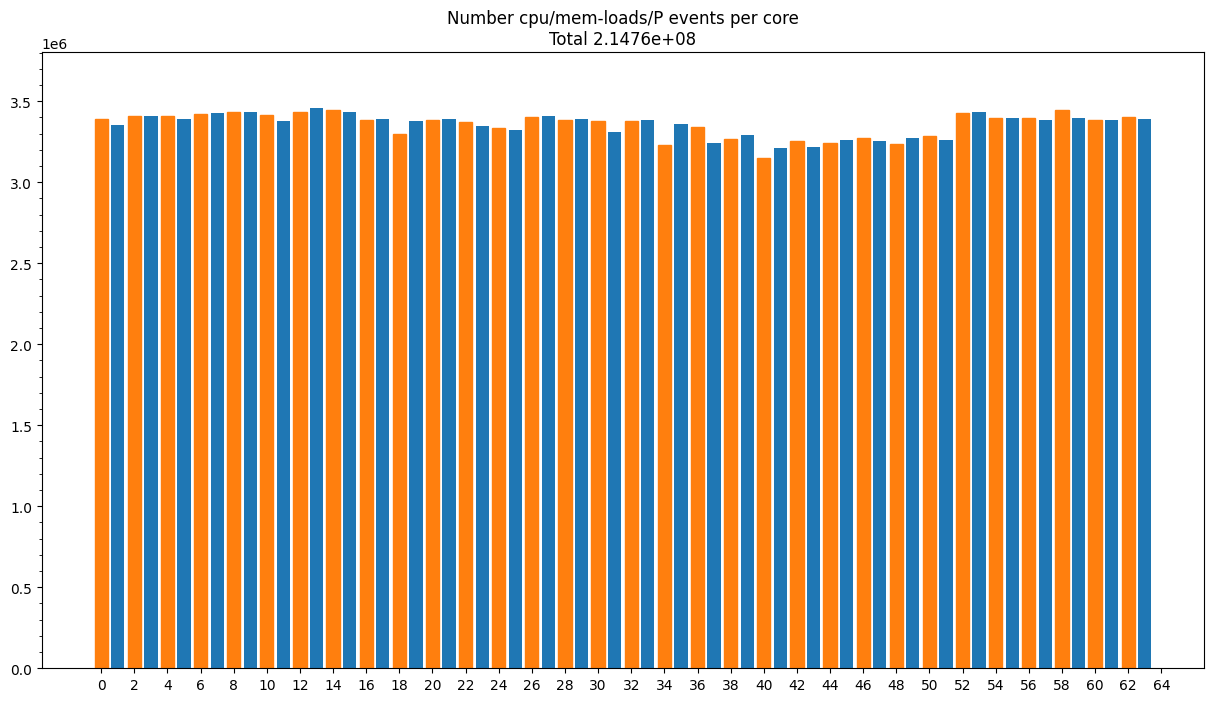

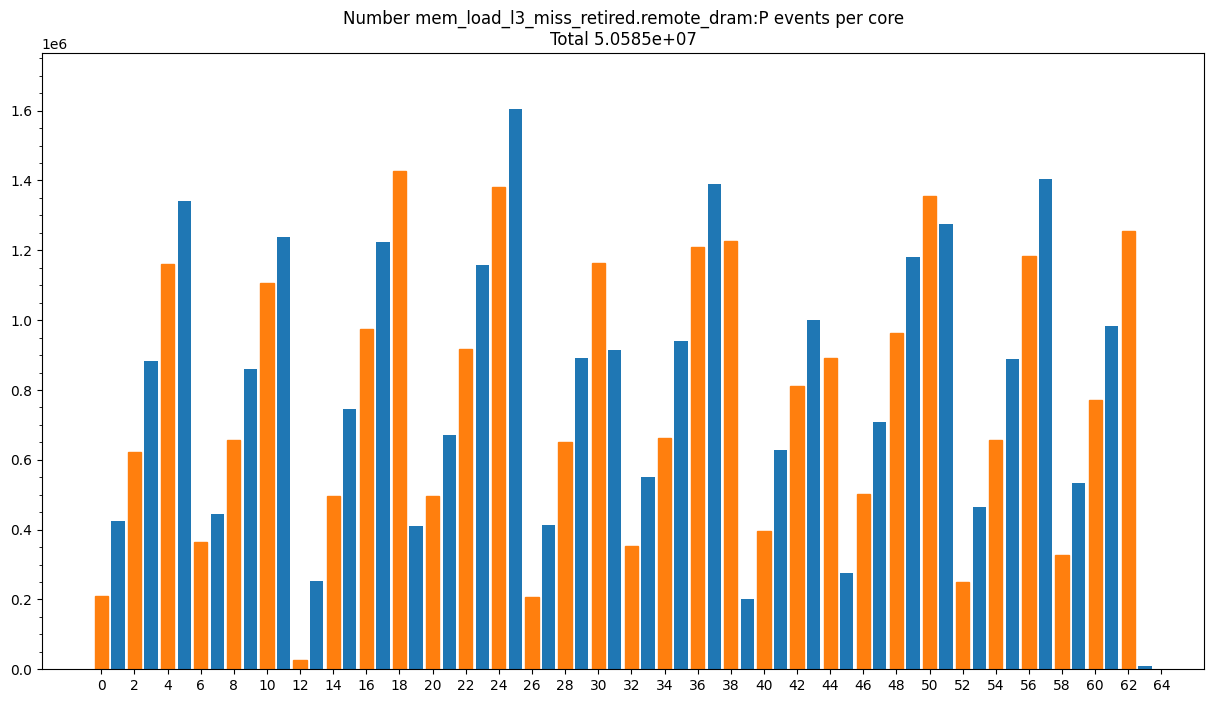

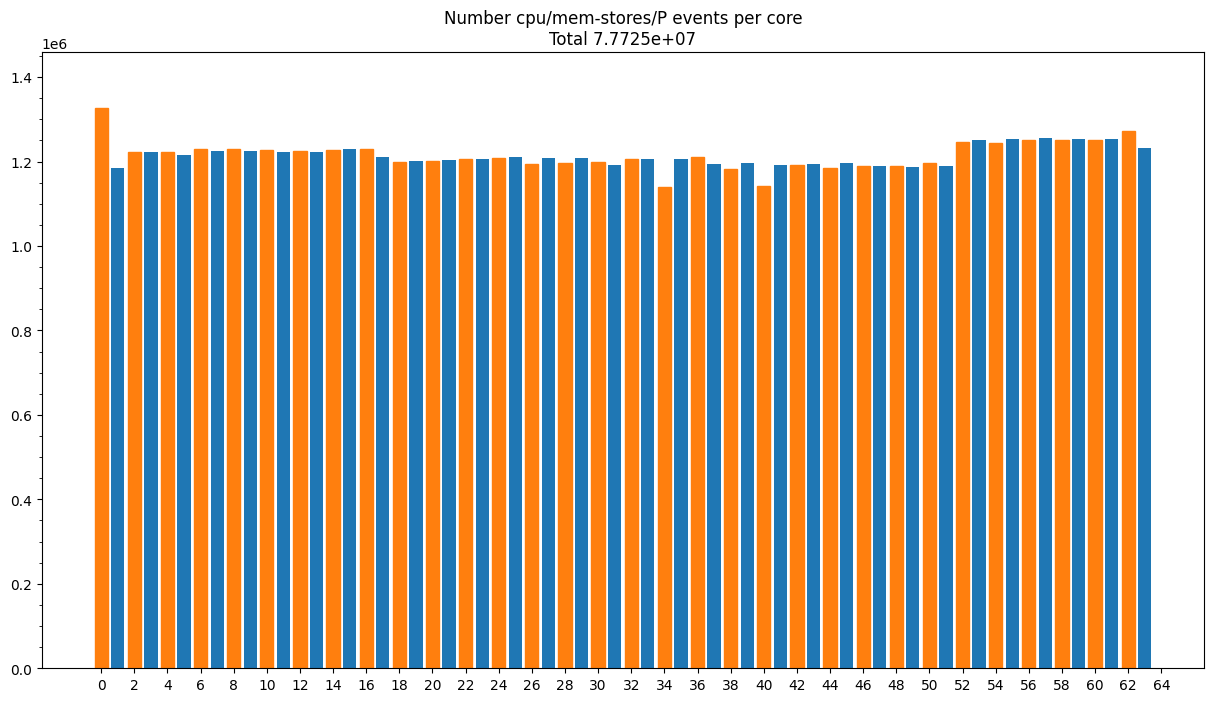

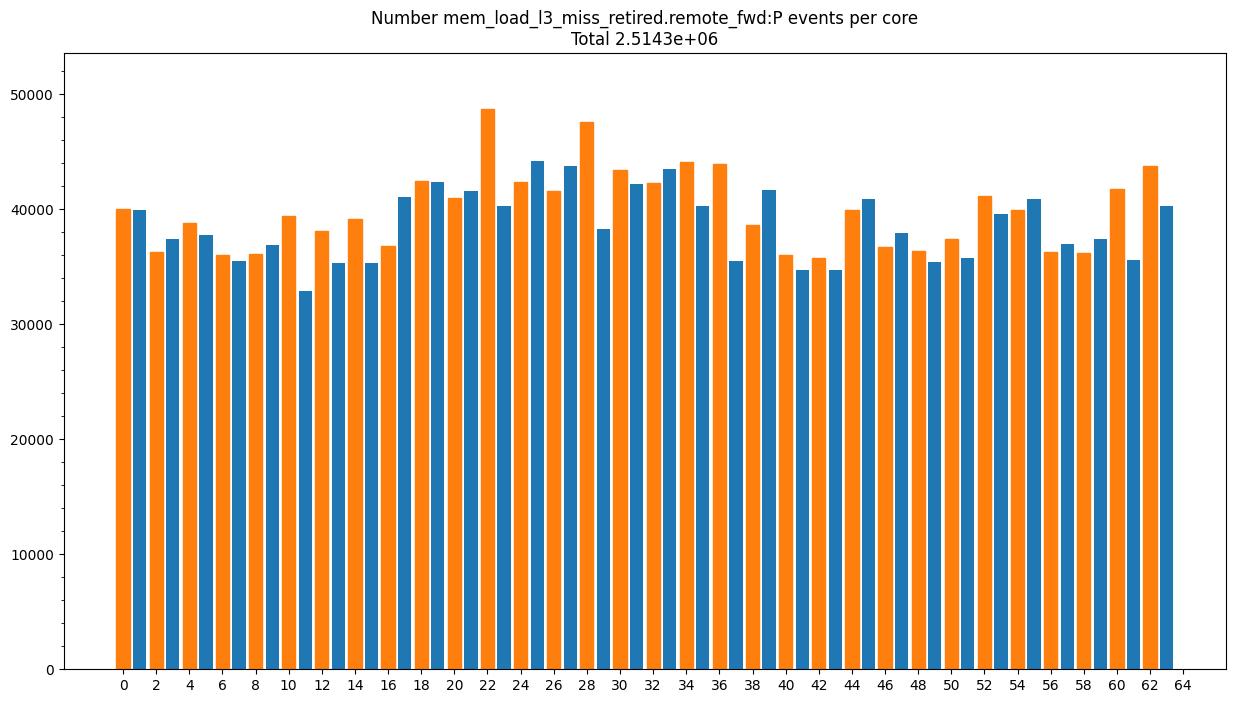

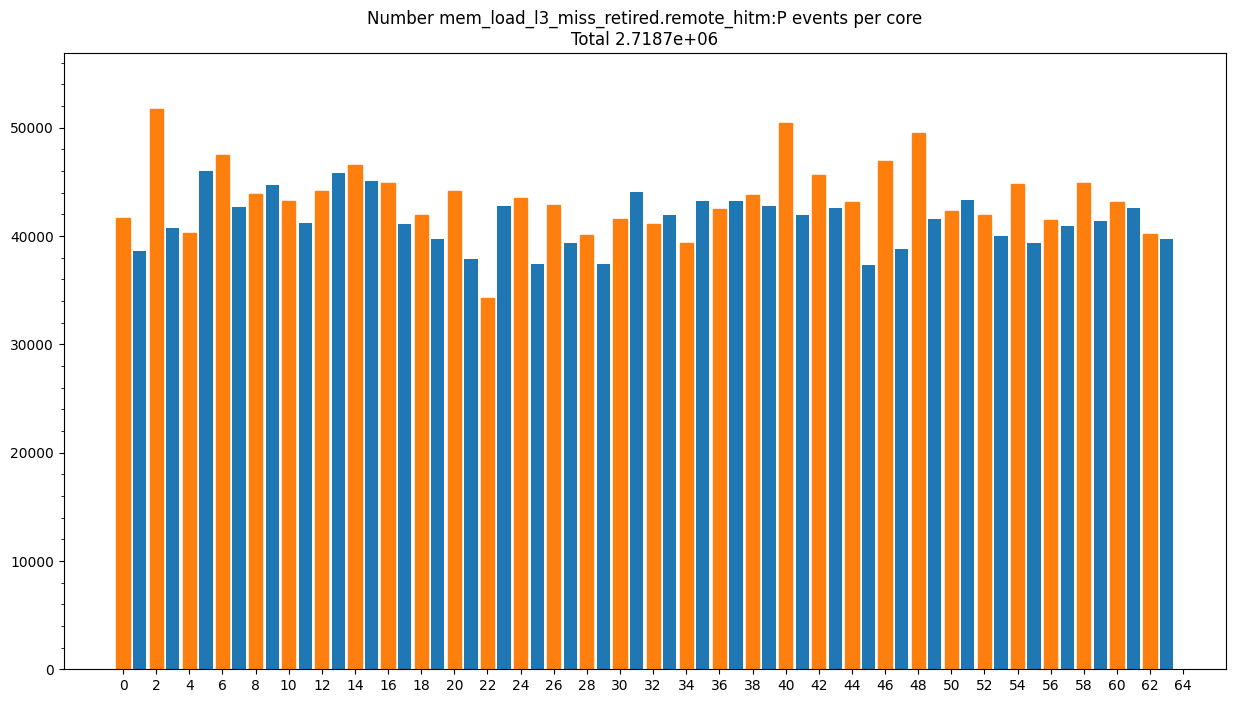

In [9]:
print(events_df['event'].unique())
for event in events_df['event'].unique() :
    plot_event_count_per_cpu(events_df, event)

In [ ]:
print(len(events_df))
phys_clusters = get_cluster_bounds(events_df['phys'].to_numpy(), 1e7, 4000)
print(phys_clusters)

events_df_sorted_phys = events_df.sort_values('phys', ignore_index=True)

plt.plot(events_df_sorted_phys.index, events_df_sorted_phys['phys'])
for cluster in phys_clusters :
    plt.axhline(y=cluster[0], color='g', linestyle='--', linewidth=0.2)
    plt.axhline(y=cluster[1], color='g', linestyle='--', linewidth=0.2)
    
for event in events_df_sorted_phys['event'].unique() :
    if "l3_miss_retired.remote_dram" not in event:
        continue
    # plot_event_count_per_cpu(events_df_sorted_phys, event)
    filtered_df = events_df_sorted_phys.loc[events_df_sorted_phys['event'] == event]
    plt.scatter(filtered_df.index, filtered_df['phys'], label=event, c='r', s=2, alpha=0.8, zorder=10)

# plt.scatter(l3_remote_df.index, l3_remote_df['phys'], s=2, color='r', alpha=0.1)

plt.axhline(y=NODE_1_PHYS_ADDR_START, color='r', linestyle='--', linewidth=0.8)
plt.gcf().set_size_inches(20, 20)
plt.title("Physical addresses ordered")
plt.legend(title='Cache Result', loc="best")
plt.show()

# events_df_sorted_phys

In [ ]:
# EventCluster = namedtuple('EventCluster', ['min_val', 'max_val', 'total_count', 'count_per_cpu'])

def get_clusters_that_contain_event(df: pd.DataFrame, clusters: list, event: str):
    # clusters could be converted to named tuple
    res = []
    for cluster in clusters:
        bounded_subset = filter_in_bounds(df, 'phys', cluster)
        event_subset = bounded_subset.loc[bounded_subset['event'] == event]
        if len(event_subset) > 0 :
            cpuids = event_subset['cpuid'].unique()
            count_per_cpu: List[Tuple[int, int]] = []
            for cid in cpuids:
                number = (event_subset['cpuid'] == cid).sum()
                count_per_cpu.append((number, cid))
            # display(event_subset)
            res.append((cluster[0], cluster[1], len(event_subset), sorted(count_per_cpu, reverse=True)))
    return sorted(res, reverse=True, key=lambda x: x[2])
    

In [ ]:
clusters_for_event = get_clusters_that_contain_event(events_df, phys_clusters, "mem_load_l3_miss_retired.remote_dram:P")
for i, cluster in enumerate(clusters_for_event) :
    print(f"Cluster {i} :", cluster)

In [ ]:
# 'cpu/mem-loads/P' 'cpu/mem-stores/P'
#  'mem_load_l3_miss_retired.local_dram:P'
#  'mem_load_l3_miss_retired.remote_dram:P'
#  'mem_load_l3_miss_retired.remote_hitm:P'
#  'mem_load_l3_miss_retired.remote_fwd:P']

def plot_phys(df: pd.DataFrame, phys_bounds: tuple, cpuid = [], exclude_cpuid = [], min_t = None, max_t = None) :
    cpu_df = df.loc[df['cpuid'].isin(cpuid)] if cpuid else df
    cpu_df = df.loc[~df['cpuid'].isin(exclude_cpuid)] if exclude_cpuid else cpu_df
    bounded_df = filter_in_bounds(cpu_df, 'phys', phys_bounds)
    
    if min_t is not None and max_t is not None :
        bounded_df = filter_in_bounds(bounded_df, 'time', (min_t, max_t))
        
    loads_df = bounded_df.loc[bounded_df['event'] == "cpu/mem-loads/P"]
    stores_df = bounded_df.loc[bounded_df['event'] == "cpu/mem-stores/P"]
    l3_miss_remote_df = bounded_df.loc[bounded_df['event'] == "mem_load_l3_miss_retired.remote_dram:P"]
    
    plt.scatter(loads_df['time'], loads_df['phys'], label="Memory loads", color='tab:green', s=3, alpha=0.5, zorder=10)
    plt.scatter(stores_df['time'], stores_df['phys'], label="Memory stores", color='tab:green', s=3, alpha=0.5, zorder=10)
    plt.scatter(l3_miss_remote_df['time'], l3_miss_remote_df['phys'], label="l3 miss remote dram", color='r', s=3, alpha=0.5, zorder=10)
    
    cpuids = bounded_df['cpuid'].unique()
    for cid in cpuids :
        curr_df = bounded_df.loc[bounded_df['cpuid'] == cid]
        plt.plot(curr_df['time'], curr_df['phys'], label=f"CPU {cid}", linestyle='--', linewidth=0.4, alpha=0.5)
        
        # break

    # fig = plt.gcf()
    # if width is None :
    #     width = 28
    # if height is None :
    #     height = 12
    # plt.gcf().set_size_inches(120, 60)
    plt.gcf().set_size_inches(60, 30)
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    plt.xlabel('Time')
    plt.ylabel('Phys')
    plt.title('Scatter Plot of Time vs Phys with Cache Results Colored')
    plt.legend(title='Cache Result')
    plt.show()

In [ ]:
# plot_phys(events_df, clusters_for_event[14], exclude_cpuid=[62], min_t=1.40, max_t=1.45)

In [ ]:
plot_phys(events_df, clusters_for_event[0])